## 📊 Passing Performance & Expected Pass (xP) Analysis in Women’s Football

**Purpose:** Analyse player passing behaviour using Expected Pass (xP) metrics, comparing pass difficulty with actual completion to evaluate passing performance  
**Competitions:** Women’s club and international competitions available in StatsBomb Open Data, with particular emphasis on Euros and World Cup  
**Data Sources:** Event data, match metadata, and lineup information from Statsbomb Open Data  
**Methods:** Expected pass modelling, player competition-level aggregation, pass outcome comparison (completed vs expected), and contextual role analysis using match lineups  
**Medium Articles:** TBC   
**Author:**  [Victoria Friss de Kereki](https://www.linkedin.com/in/victoria-friss-de-kereki/)   
**Related Work:** [Building Expected Passes xP for Womens Football](https://github.com/vickyfriss/Football-analytics/blob/main/202601%20-%202%20-%20Building%20Expected%20Passes%20xP%20for%20Womens%20Football.ipynb)   

---

**Notebook first written:** `14/02/2026`  
**Last updated:** `15/02/2026`  

> This notebook evaluates player passing performance using Expected Pass (xP), measuring how difficult passes are relative to completion outcomes.  
>  
> Passing metrics are analysed by player and competition — especially major international tournaments — and contextualised using lineup data to understand how player roles and positioning relate to passing behaviour across tournaments.


-------------------------

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load datasets created in previous work

In [2]:
data_folder = r"C:\Users\vicky\Desktop\Football-analytics\Datasets\xP_master"

# Dictionary to hold each DataFrame
dfs = {}

# Load each file
for filename in os.listdir(data_folder):
    if filename.endswith(".parquet"):
        full_path = os.path.join(data_folder, filename)
        dfs[filename] = pd.read_parquet(full_path)
        print(f"Loaded {filename} with shape {dfs[filename].shape}")

# Access individual DataFrames, for example:
competitions_df = dfs['competitions.parquet']
matches_df = dfs['matches.parquet']
model_features_df = dfs['model_features_X.parquet']
passes_xp_df = dfs['passes_features_with_xp.parquet']
passes_raw_df = dfs['passes_raw.parquet']

Loaded competitions.parquet with shape (8, 12)
Loaded matches.parquet with shape (540, 22)
Loaded model_features_X.parquet with shape (495781, 213)
Loaded passes_features_with_xp.parquet with shape (495781, 349)
Loaded passes_raw.parquet with shape (496100, 122)


In [3]:
passes_xp_df.head()

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,...,pp_From Counter,pp_From Free Kick,pp_From Goal Kick,pp_From Keeper,pp_From Kick Off,pp_From Throw In,pp_Other,pp_Regular Play,completed,xP
0,None,None,None,None,None,None,None,None,None,None,...,False,False,False,False,True,False,False,False,1,0.769447
1,None,None,None,None,None,None,None,None,None,None,...,False,False,False,False,True,False,False,False,1,0.982276
2,None,None,None,None,None,None,None,None,None,None,...,False,False,False,False,True,False,False,False,1,0.952742
3,None,None,None,None,None,None,None,None,None,None,...,False,False,False,False,True,False,False,False,1,0.753151
4,None,None,None,None,None,None,None,None,None,None,...,False,False,False,False,True,False,False,False,1,0.811358


In [4]:
len(passes_xp_df)

495781

In [5]:
matches_df.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3775648,2021-02-28,15:00:00.000,England - FA Women's Super League,2020/2021,Aston Villa,Arsenal WFC,0,4,available,...,2021-06-13T16:17:31.694,11,Regular Season,Poundland Bescot Stadium,Lisa Benn,Marcus Bignot,Joseph Montemurro,1.1.0,2,2
1,3775609,2021-04-28,20:30:00.000,England - FA Women's Super League,2020/2021,Arsenal WFC,West Ham United LFC,2,0,available,...,2021-06-13T16:17:31.694,13,Regular Season,Meadow Park,Emily Heaslip,Joseph Montemurro,Olli Harder,1.1.0,2,2
2,3775633,2021-02-06,13:30:00.000,England - FA Women's Super League,2020/2021,Aston Villa,Tottenham Hotspur Women,1,0,available,...,2021-06-13T16:17:31.694,14,Regular Season,Poundland Bescot Stadium,Jane Simms,Marcus Bignot,Rehanne Skinner,1.1.0,2,2
3,3775570,2021-03-28,13:30:00.000,England - FA Women's Super League,2020/2021,Brighton & Hove Albion WFC,Everton LFC,0,5,available,...,2021-06-13T16:17:31.694,18,Regular Season,Broadfield Stadium,Christina Hattersley,Hope Patricia Powell,Willie Kirk,1.1.0,2,2
4,3775581,2021-03-28,15:30:00.000,England - FA Women's Super League,2020/2021,Chelsea FCW,Aston Villa,2,0,available,...,2021-06-13T16:17:31.694,18,Regular Season,Kingsmeadow,Sarah Garratt,Emma Hayes,Marcus Bignot,1.1.0,2,2


# 2. Calibration

**∑(completed−xP)**

**Interpretation**  

≈ 0 → well calibrated  
The model predicts the right number of successful passes overall.

Positive → model underestimates success  
Players complete more passes than expected.

Negative → model overestimates success  
Model predicts too many successful passes.

### Calibration summary per tournament

,n_passes,total_completed,total_xP,difference,relative_error,mean_error_per_pass,ci_lower,ci_upper
competition_name,,,,,,,,
England - FA Women's Super League,"298,215.00","219,836.00","220,331.05",-495.05,-0.22%,-0.0017,-889.50,-83.02
Europe - UEFA Women's Euro,"58,344.00","44,843.00","43,885.64",957.36,2.18%,0.0164,784.34,"1,123.36"
International - Women's World Cup,"107,167.00","79,708.00","79,163.88",544.12,0.69%,0.0051,308.98,787.43
United States of America - NWSL,"32,055.00","22,065.00","23,049.78",-984.78,-4.27%,-0.0307,"-1,119.17",-851.31


C:\Users\vicky\AppData\Local\Temp\ipykernel_24748\892619468.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('xP_bin')


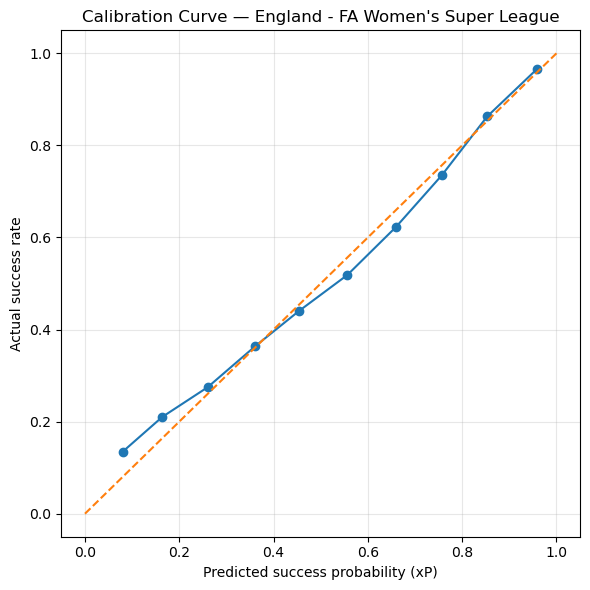

C:\Users\vicky\AppData\Local\Temp\ipykernel_24748\892619468.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('xP_bin')


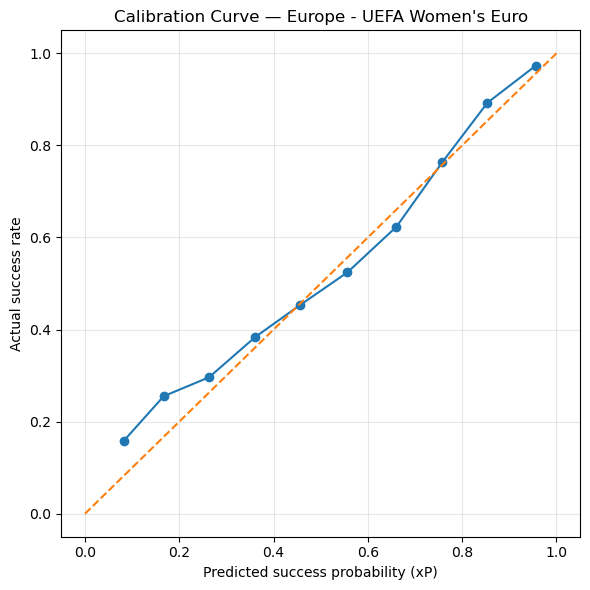

C:\Users\vicky\AppData\Local\Temp\ipykernel_24748\892619468.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('xP_bin')


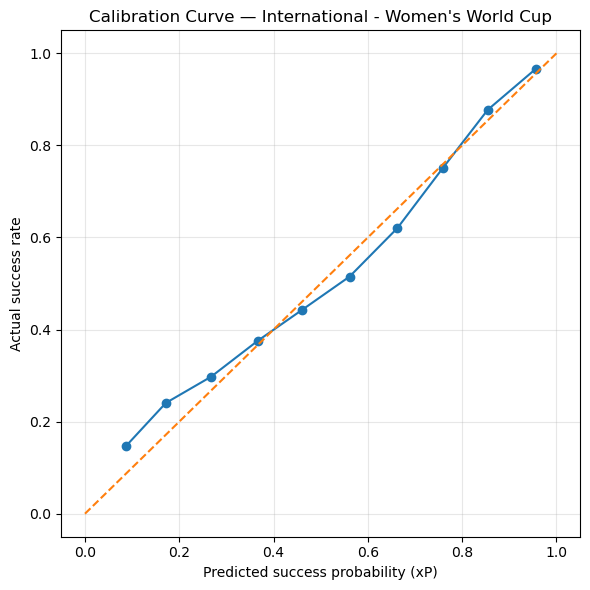

C:\Users\vicky\AppData\Local\Temp\ipykernel_24748\892619468.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('xP_bin')


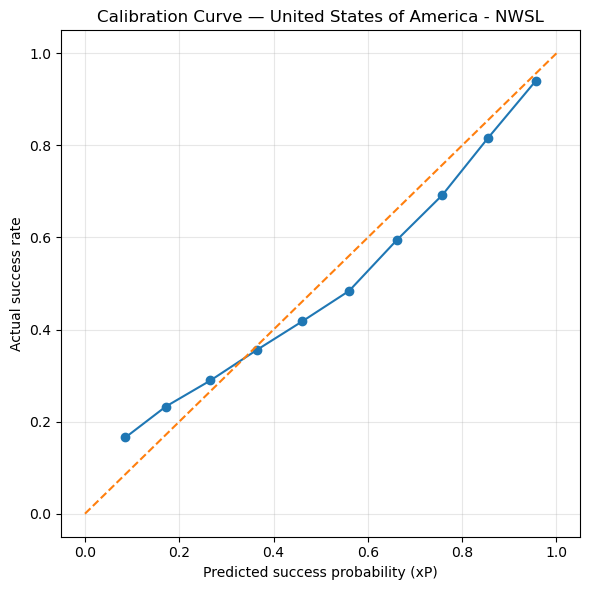

### Calibration — Euros and World Cup

,n_passes,total_completed,total_xP,difference,relative_error,mean_error_per_pass,ci_lower,ci_upper
competition_name,,,,,,,,
Europe - UEFA Women's Euro,"58,344.00","44,843.00","43,885.64",957.36,2.18%,0.0164,784.34,"1,123.36"
International - Women's World Cup,"107,167.00","79,708.00","79,163.88",544.12,0.69%,0.0051,308.98,787.43


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown



# 1. Calibration summary per tournament


calibration_summary = (
    passes_xp_df
    .groupby('competition_name')
    .agg(
        n_passes=('xP', 'size'),
        total_completed=('completed', 'sum'),
        total_xP=('xP', 'sum')
    )
)

calibration_summary['difference'] = (
    calibration_summary['total_completed'] - calibration_summary['total_xP']
)

calibration_summary['relative_error'] = (
    calibration_summary['difference'] / calibration_summary['total_xP']
)

calibration_summary['mean_error_per_pass'] = (
    calibration_summary['difference'] / calibration_summary['n_passes']
)



# 2. Bootstrap confidence intervals


def bootstrap_total_difference(df, n_boot=2000, seed=14):
    rng = np.random.default_rng(seed)
    diffs = []

    values = df[['completed', 'xP']].to_numpy()

    for _ in range(n_boot):
        sample_idx = rng.integers(0, len(values), len(values))
        sample = values[sample_idx]
        diffs.append(sample[:, 0].sum() - sample[:, 1].sum())

    return np.percentile(diffs, [2.5, 97.5])


ci_results = []

for comp, group in passes_xp_df.groupby('competition_name'):
    low, high = bootstrap_total_difference(group)
    ci_results.append({
        'competition_name': comp,
        'ci_lower': low,
        'ci_upper': high
    })

ci_df = pd.DataFrame(ci_results).set_index('competition_name')
calibration_summary = calibration_summary.join(ci_df)



# 3. Pretty display function


def display_calibration_table(df, title):

    formatted = df.copy()

    formatted['relative_error'] = (formatted['relative_error'] * 100).map("{:.2f}%".format)
    formatted['mean_error_per_pass'] = formatted['mean_error_per_pass'].round(4)

    for col in ['n_passes', 'total_completed', 'total_xP', 'difference', 'ci_lower', 'ci_upper']:
        formatted[col] = formatted[col].round(2).map('{:,.2f}'.format)

    display(Markdown(f"### {title}"))
    display(formatted)


display_calibration_table(
    calibration_summary,
    "Calibration summary per tournament"
)



# 4. Calibration curves


def plot_calibration_curve(df, competition, bins=10):

    df = df.copy()
    df['xP_bin'] = pd.cut(df['xP'], bins=bins)

    calib = (
        df
        .groupby('xP_bin')
        .agg(
            mean_predicted=('xP', 'mean'),
            actual_success=('completed', 'mean'),
            count=('completed', 'size')
        )
        .dropna()
    )

    plt.figure(figsize=(6, 6))
    plt.plot(calib['mean_predicted'], calib['actual_success'], marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f'Calibration Curve — {competition}')
    plt.xlabel('Predicted success probability (xP)')
    plt.ylabel('Actual success rate')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


for comp, group in passes_xp_df.groupby('competition_name'):
    plot_calibration_curve(group, comp)



# 5. Focus on Euros and World Cup


target_tournaments = [
    "Europe - UEFA Women's Euro",
    "International - Women's World Cup"
]

focus_summary = calibration_summary.loc[
    calibration_summary.index.intersection(target_tournaments)
]

display_calibration_table(
    focus_summary,
    "Calibration — Euros and World Cup"
)

In [31]:
# Linear Scaling / Platt Scaling (simple linear)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def linear_recalibrate(df, prob_col="xP", outcome_col="completed"):
    data = df.copy()
    eps = 1e-6
    data["p_clip"] = data[prob_col].clip(eps,1-eps)

    # fit simple linear regression
    model = LinearRegression()
    model.fit(data[["p_clip"]], data[outcome_col])

    a = model.intercept_
    b = model.coef_[0]

    data["xP_linear_calibrated"] = a + b * data["p_clip"]
    # clip to [0,1]
    data["xP_linear_calibrated"] = data["xP_linear_calibrated"].clip(0,1)

    return data, a, b

def plot_linear(df, title):
    df_before = df.copy()
    df_after = df.copy()
    
    bins=10
    df_before["bin"] = pd.cut(df_before["xP"], bins=bins)
    df_after["bin"] = pd.cut(df_after["xP_linear_calibrated"], bins=bins)
    
    before_curve = df_before.groupby("bin").agg(predicted=("xP","mean"), actual=("completed","mean")).dropna()
    after_curve = df_after.groupby("bin").agg(predicted=("xP_linear_calibrated","mean"), actual=("completed","mean")).dropna()
    
    plt.figure(figsize=(6,6))
    plt.plot(before_curve["predicted"], before_curve["actual"], marker="o", label="Before")
    plt.plot(after_curve["predicted"], after_curve["actual"], marker="o", label="Linear Calibrated")
    plt.plot([0,1],[0,1],"--", label="Perfect calibration")
    plt.xlabel("Predicted probability")
    plt.ylabel("Actual success rate")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
def show_changes_linear(df,n=10):
    df["abs_change"] = (df["xP_linear_calibrated"] - df["xP"]).abs()
    return df.sort_values("abs_change", ascending=False).head(n)

In [32]:
# Logistic Recalibration (Platt scaling in logit space)

from sklearn.linear_model import LogisticRegression

def logit(p): return np.log(p/(1-p))
def inv_logit(x): return 1/(1+np.exp(-x))

def logistic_recalibrate(df, prob_col="xP", outcome_col="completed"):
    data = df.copy()
    eps = 1e-6
    data["p_clip"] = data[prob_col].clip(eps,1-eps)
    data["logit_xp"] = logit(data["p_clip"])

    model = LogisticRegression(solver="lbfgs")
    model.fit(data[["logit_xp"]], data[outcome_col])

    a = model.intercept_[0]
    b = model.coef_[0][0]

    calibrated_logit = a + b*data["logit_xp"]
    data["xP_logistic_calibrated"] = inv_logit(calibrated_logit)

    return data, a, b

def plot_logistic(df, title):
    bins=10
    df["bin_before"] = pd.cut(df["xP"], bins=bins)
    df["bin_after"] = pd.cut(df["xP_logistic_calibrated"], bins=bins)

    before_curve = df.groupby("bin_before").agg(predicted=("xP","mean"), actual=("completed","mean")).dropna()
    after_curve = df.groupby("bin_after").agg(predicted=("xP_logistic_calibrated","mean"), actual=("completed","mean")).dropna()

    plt.figure(figsize=(6,6))
    plt.plot(before_curve["predicted"], before_curve["actual"], marker="o", label="Before")
    plt.plot(after_curve["predicted"], after_curve["actual"], marker="o", label="Logistic Calibrated")
    plt.plot([0,1],[0,1],"--", label="Perfect calibration")
    plt.xlabel("Predicted probability")
    plt.ylabel("Actual success rate")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def show_changes_logistic(df,n=10):
    df["abs_change"] = (df["xP_logistic_calibrated"] - df["xP"]).abs()
    return df.sort_values("abs_change", ascending=False).head(n)


In [33]:
# Isotonic Regression (Non-parametric monotone fit)

from sklearn.isotonic import IsotonicRegression

def isotonic_recalibrate(df, prob_col="xP", outcome_col="completed"):
    data = df.copy()
    iso = IsotonicRegression(out_of_bounds="clip")
    data["xP_iso_calibrated"] = iso.fit_transform(data[prob_col], data[outcome_col])
    return data, iso

def plot_isotonic(df, title):
    bins=10
    df["bin_before"] = pd.cut(df["xP"], bins=bins)
    df["bin_after"] = pd.cut(df["xP_iso_calibrated"], bins=bins)

    before_curve = df.groupby("bin_before").agg(predicted=("xP","mean"), actual=("completed","mean")).dropna()
    after_curve = df.groupby("bin_after").agg(predicted=("xP_iso_calibrated","mean"), actual=("completed","mean")).dropna()

    plt.figure(figsize=(6,6))
    plt.plot(before_curve["predicted"], before_curve["actual"], marker="o", label="Before")
    plt.plot(after_curve["predicted"], after_curve["actual"], marker="o", label="Isotonic Calibrated")
    plt.plot([0,1],[0,1],"--", label="Perfect calibration")
    plt.xlabel("Predicted probability")
    plt.ylabel("Actual success rate")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def show_changes_isotonic(df,n=10):
    df["abs_change"] = (df["xP_iso_calibrated"] - df["xP"]).abs()
    return df.sort_values("abs_change", ascending=False).head(n)

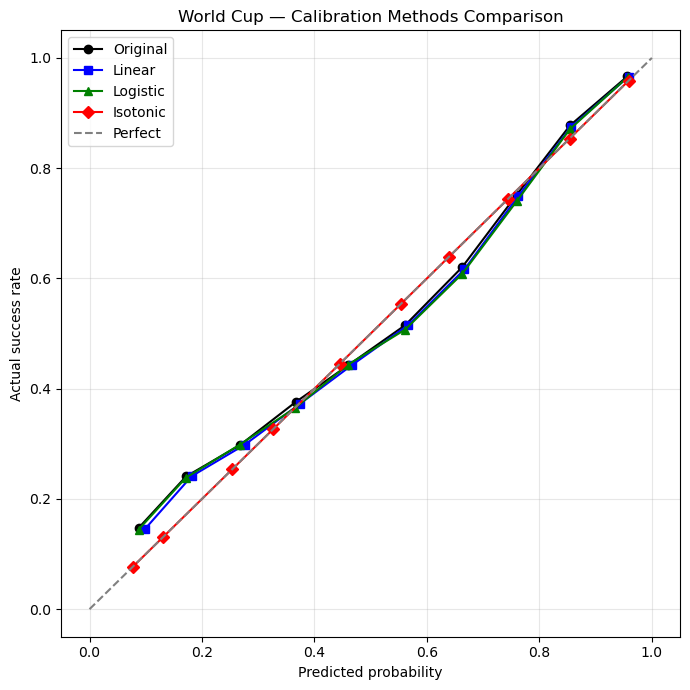

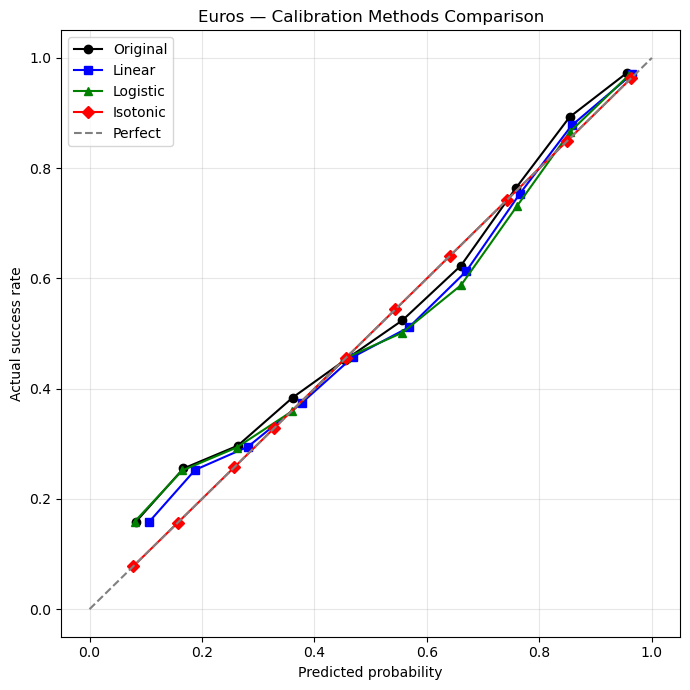

World Cup — Top 5 passes that changed the most (showing completed)


,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,team,player,minute,second,completed,xP,xP_linear,xP_logistic,xP_isotonic,max_change
98114,68338,2019-06-19,21:00:00.000,International - Women's World Cup,2019,Scotland Women's,Argentina Women's,3,3,Argentina Women's,María Florencia Bonsegundo,16,29,1,0.114176,0.124971,0.114736,0.232681,0.118505
9800,3901832,2023-08-08,11:00:00.000,International - Women's World Cup,2023,Colombia Women's,Jamaica Women's,1,0,Colombia Women's,Ana María Guzmán Zapata,50,48,1,0.114184,0.124979,0.114745,0.232681,0.118497
92214,69202,2019-06-28,21:00:00.000,International - Women's World Cup,2019,France Women's,United States Women's,1,2,France Women's,Eugénie Le Sommer,61,27,0,0.114189,0.124984,0.114750,0.232681,0.118492
9991,3901832,2023-08-08,11:00:00.000,International - Women's World Cup,2023,Colombia Women's,Jamaica Women's,1,0,Jamaica Women's,Chantelle Swaby,74,39,0,0.114197,0.124991,0.114757,0.232681,0.118484
19454,3901736,2023-08-07,13:30:00.000,International - Women's World Cup,2023,Australia Women's,Denmark Women's,2,0,Australia Women's,Ellie Madison Carpenter,18,39,0,0.114198,0.124993,0.114759,0.232681,0.118482


Euros — Top 5 passes that changed the most (showing completed)


,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,team,player,minute,second,completed,xP,xP_linear,xP_logistic,xP_isotonic,max_change
45769,3835329,2022-07-12,18:00:00.000,Europe - UEFA Women's Euro,2022,Denmark Women's,WNT Finland,1,0,Denmark Women's,Janni Thomsen,17,2,1,0.095536,0.119145,0.093453,0.210654,0.115118
50722,3835341,2022-07-18,21:00:00.000,Europe - UEFA Women's Euro,2022,Italy Women's,Belgium Women's,0,1,Italy Women's,Barbara Bonansea,46,58,0,0.095628,0.119236,0.093548,0.210654,0.115025
21657,3998845,2025-07-06,16:00:00.000,Europe - UEFA Women's Euro,2025,Norway Women's,WNT Finland,2,1,Norway Women's,Cecilie Fiskerstrand,44,19,0,0.095670,0.119277,0.093591,0.210654,0.114984
9201,3998859,2025-07-13,19:00:00.000,Europe - UEFA Women's Euro,2025,Netherlands Women's,France Women's,2,5,Netherlands Women's,Dominique Johanna Anna Petrone Janssen,59,10,0,0.095832,0.119438,0.093758,0.210654,0.114822
19440,3998847,2025-07-07,16:00:00.000,Europe - UEFA Women's Euro,2025,Spain Women's,Belgium Women's,6,2,Belgium Women's,Janice Cayman,6,24,1,0.095898,0.119503,0.093826,0.210654,0.114756


In [49]:
import matplotlib.pyplot as plt
import pandas as pd

# ==========================
# 1️⃣ Function to prepare calibration curves
# ==========================
def get_calibration_curve(df, prob_col, outcome_col="completed", bins=10):
    df_copy = df.copy()
    df_copy["bin"] = pd.cut(df_copy[prob_col], bins=bins)
    
    curve = df_copy.groupby("bin", observed=True).agg(
        predicted=(prob_col, "mean"),
        actual=(outcome_col, "mean")
    ).dropna()
    
    return curve

# ==========================
# 2️⃣ Function to plot multiple calibration methods on one figure
# ==========================
def plot_multiple_methods(df, methods_dict, title, bins=10):
    plt.figure(figsize=(7,7))
    markers = {"Original":"o","Linear":"s","Logistic":"^","Isotonic":"D"}
    colors = {"Original":"black","Linear":"blue","Logistic":"green","Isotonic":"red"}

    for name, col in methods_dict.items():
        if col not in df.columns:
            continue
        curve = get_calibration_curve(df, col, bins=bins)
        plt.plot(curve["predicted"], curve["actual"], 
                 marker=markers.get(name,"o"), 
                 label=name, color=colors.get(name,"gray"))
    
    # Perfect calibration
    plt.plot([0,1],[0,1],"--", color="gray", label="Perfect")
    plt.xlabel("Predicted probability")
    plt.ylabel("Actual success rate")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ==========================
# 3️⃣ Prepare both tournaments
# ==========================
worldcup = passes_xp_df[passes_xp_df["competition_name"]=="International - Women's World Cup"].copy()
euros     = passes_xp_df[passes_xp_df["competition_name"]=="Europe - UEFA Women's Euro"].copy()

# Apply the three calibrations
# World Cup
wc_linear, _, _ = linear_recalibrate(worldcup)
wc_log, _, _ = logistic_recalibrate(worldcup)
wc_iso, _ = isotonic_recalibrate(worldcup)

worldcup_all = worldcup.copy()
worldcup_all["xP_linear"] = wc_linear["xP_linear_calibrated"]
worldcup_all["xP_logistic"] = wc_log["xP_logistic_calibrated"]
worldcup_all["xP_isotonic"] = wc_iso["xP_iso_calibrated"]  # ensure consistent name

# Euros
euros_linear, _, _ = linear_recalibrate(euros)
euros_log, _, _ = logistic_recalibrate(euros)
euros_iso, _ = isotonic_recalibrate(euros)

euros_all = euros.copy()
euros_all["xP_linear"] = euros_linear["xP_linear_calibrated"]
euros_all["xP_logistic"] = euros_log["xP_logistic_calibrated"]
euros_all["xP_isotonic"] = euros_iso["xP_iso_calibrated"]  # ensure consistent name

# ==========================
# 4️⃣ Plot all methods in one figure for each tournament
# ==========================
methods = {
    "Original": "xP",
    "Linear": "xP_linear",
    "Logistic": "xP_logistic",
    "Isotonic": "xP_isotonic"
}

plot_multiple_methods(worldcup_all, methods, "World Cup — Calibration Methods Comparison")
plot_multiple_methods(euros_all, methods, "Euros — Calibration Methods Comparison")

# ==========================
# 5️⃣ Show top 5 most changed passes with match info and completed column
# ==========================
def top_changed_passes_with_completed(df, matches_df, n=5):
    df = df.copy()
    
    # Compute absolute change per method
    df["abs_change_linear"] = (df["xP_linear"] - df["xP"]).abs()
    df["abs_change_logistic"] = (df["xP_logistic"] - df["xP"]).abs()
    df["abs_change_isotonic"] = (df["xP_isotonic"] - df["xP"]).abs()
    
    # Max change across methods
    df["max_change"] = df[["abs_change_linear","abs_change_logistic","abs_change_isotonic"]].max(axis=1)
    
    # Merge match-level info
    match_cols = [
        "match_id", "match_date", "kick_off", "competition", "season",
        "home_team", "away_team", "home_score", "away_score"
    ]
    df = df.merge(matches_df[match_cols], on="match_id", how="left")
    
    # Columns to display — include 'completed' instead of pass_outcome
    cols = [
        "match_id","match_date","kick_off","competition","season",
        "home_team","away_team","home_score","away_score",
        "team","player","minute","second","completed",
        "xP","xP_linear","xP_logistic","xP_isotonic","max_change"
    ]
    available_cols = [c for c in cols if c in df.columns]
    
    # Top N most changed
    top_df = df.sort_values("max_change", ascending=False).head(n)
    return top_df[available_cols]

# --------------------------
# World Cup — top 5 changed passes
# --------------------------
print("World Cup — Top 5 passes that changed the most (showing completed)")
worldcup_top5_completed = top_changed_passes_with_completed(worldcup_all, matches_df, 5)
display(worldcup_top5_completed)

# --------------------------
# Euros — top 5 changed passes
# --------------------------
print("Euros — Top 5 passes that changed the most (showing completed)")
euros_top5_completed = top_changed_passes_with_completed(euros_all, matches_df, 5)
display(euros_top5_completed)

# 2. Download lineups from Statsbomb API to get player positions

In [6]:
# Download lineups for all matches from StatsBomb API
# and build a dataset with player position per match + tournament

from statsbombpy.api_client import NoAuthWarning
import warnings
warnings.filterwarnings("ignore", category=NoAuthWarning)

from statsbombpy import sb
import pandas as pd

all_lineups = []

match_ids = matches_df['match_id'].dropna().unique()
total_matches = len(match_ids)

for i, match_id in enumerate(match_ids, start=1):
    
    try:
        lineups = sb.lineups(match_id=match_id)

        # statsbombpy returns one dataframe per team → stack them
        for team, df in lineups.items():
            df = df.copy()
            df['team_name'] = team
            df['match_id'] = match_id
            all_lineups.append(df)

        print(f"Downloaded {i}/{total_matches} matches", end="\r")

    except Exception as e:
        print(f"\nCould not load lineup for match {match_id}: {e}")

print("\nDownload complete")


# Combine all matches
lineups_df = pd.concat(all_lineups, ignore_index=True)


# Extract position from the nested "positions" list
def extract_primary_position(pos_list):
    if isinstance(pos_list, list) and len(pos_list) > 0:
        return pos_list[0].get('position')
    return None

lineups_df['position'] = lineups_df['positions'].apply(extract_primary_position)


# Clean columns
lineups_df = lineups_df.rename(columns={'player_name': 'player'})

lineups_df = lineups_df[
    ['match_id', 'player', 'player_id', 'team_name', 'position']
]


# Add tournament / competition from matches_df
match_to_competition = matches_df.set_index('match_id')['competition'].to_dict()
lineups_df['competition_name'] = lineups_df['match_id'].map(match_to_competition)


# Optional column order
lineups_df = lineups_df[
    ['match_id', 'competition_name', 'player', 'player_id', 'team_name', 'position']
]


print(f"Finished. Successfully processed {total_matches} matches.")
lineups_df.head()

Downloaded 540/540 matches
Download complete
Finished. Successfully processed 540 matches.


,match_id,competition_name,player,player_id,team_name,position
0,3775648,England - FA Women's Super League,Anita Amma Ankyewah Asante,4657,Aston Villa,Center Back
1,3775648,England - FA Women's Super League,Stine Larsen,10102,Aston Villa,Left Center Forward
2,3775648,England - FA Women's Super League,Chloe Arthur,10193,Aston Villa,Left Center Midfield
3,3775648,England - FA Women's Super League,Emma Follis,15557,Aston Villa,Right Center Forward
4,3775648,England - FA Women's Super League,Marisa Ewers,15565,Aston Villa,Center Defensive Midfield


In [7]:
# list all unique positions
all_positions = sorted(lineups_df['position'].dropna().unique())

print("All positions in dataset:")
for p in all_positions:
    print(p)

All positions in dataset:
Center Attacking Midfield
Center Back
Center Defensive Midfield
Center Forward
Center Midfield
Goalkeeper
Left Attacking Midfield
Left Back
Left Center Back
Left Center Forward
Left Center Midfield
Left Defensive Midfield
Left Midfield
Left Wing
Left Wing Back
Right Attacking Midfield
Right Back
Right Center Back
Right Center Forward
Right Center Midfield
Right Defensive Midfield
Right Midfield
Right Wing
Right Wing Back
Secondary Striker


In [8]:
# Map detailed StatsBomb positions into 4 main categories
position_map = {
    # goalkeeper
    "Goalkeeper": "Goalkeeper",

    # defenders (including wing backs)
    "Center Back": "Defender",
    "Left Back": "Defender",
    "Right Back": "Defender",
    "Left Center Back": "Defender",
    "Right Center Back": "Defender",
    "Left Wing Back": "Defender",
    "Right Wing Back": "Defender",

    # midfield (defensive / central / attacking / wide)
    "Center Midfield": "Midfielder",
    "Left Center Midfield": "Midfielder",
    "Right Center Midfield": "Midfielder",
    "Left Midfield": "Midfielder",
    "Right Midfield": "Midfielder",
    "Center Defensive Midfield": "Midfielder",
    "Left Defensive Midfield": "Midfielder",
    "Right Defensive Midfield": "Midfielder",
    "Center Attacking Midfield": "Midfielder",
    "Left Attacking Midfield": "Midfielder",
    "Right Attacking Midfield": "Midfielder",

    # forwards
    "Center Forward": "Forward",
    "Left Center Forward": "Forward",
    "Right Center Forward": "Forward",
    "Left Wing": "Forward",
    "Right Wing": "Forward",
    "Secondary Striker": "Forward",
}

# Apply mapping
lineups_df['position_group'] = lineups_df['position'].map(position_map)

# Optional: check for positions that didn't map
unmapped = lineups_df[lineups_df['position_group'].isna()]['position'].unique()
print("Unmapped positions:", unmapped)

Unmapped positions: [None]


In [9]:
# 1. Count number of main position categories per player per tournament

main_pos_counts = (
    lineups_df
    .groupby(['player', 'competition_name'])['position_group']
    .nunique()
    .reset_index(name='num_main_categories')
)

distribution_main = main_pos_counts['num_main_categories'].value_counts().sort_index()

print("Player–tournament cases by number of MAIN position categories:")
print(distribution_main)

print("\nPlayed in exactly 2 main categories:",
      (main_pos_counts['num_main_categories'] == 2).sum())

print("Played in 3 or more main categories:",
      (main_pos_counts['num_main_categories'] >= 3).sum())


# 2. Most common + second most common MAIN category
def get_top_main_positions(group):
    counts = group['position_group'].value_counts()
    
    primary = counts.index[0] if len(counts) >= 1 else None
    secondary = counts.index[1] if len(counts) >= 2 else None
    
    return pd.Series({
        'primary_main_position': primary,
        'secondary_main_position': secondary
    })


player_tournament_main_positions = (
    lineups_df
    .groupby(['player', 'competition_name'])
    .apply(get_top_main_positions)
    .reset_index()
)


# 3. Which players played multiple main categories in same tournament?
multi_main = main_pos_counts[main_pos_counts['num_main_categories'] > 1]

print("\nPlayers who played more than one main category in a tournament:")
print(multi_main.head())

print("\nTotal player–tournament cases with multiple main categories:",
      len(multi_main))

Player–tournament cases by number of MAIN position categories:
num_main_categories
0     371
1    1214
2     566
3     164
Name: count, dtype: int64

Played in exactly 2 main categories: 566
Played in 3 or more main categories: 164

Players who played more than one main category in a tournament:
                 player                   competition_name  \
1  Abbey-Leigh Stringer  England - FA Women's Super League   
2            Abbi Grant  England - FA Women's Super League   
4          Abbie Larkin  International - Women's World Cup   
5           Abbie Magee         Europe - UEFA Women's Euro   
6         Abbie McManus  England - FA Women's Super League   

   num_main_categories  
1                    3  
2                    2  
4                    2  
5                    2  
6                    2  

Total player–tournament cases with multiple main categories: 730


C:\Users\vicky\AppData\Local\Temp\ipykernel_24748\1205206569.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_top_main_positions)


In [10]:
player_tournament_main_positions.head()

,player,competition_name,primary_main_position,secondary_main_position
0,Abbey Jones,England - FA Women's Super League,None,None
1,Abbey-Leigh Stringer,England - FA Women's Super League,Midfielder,Defender
2,Abbi Grant,England - FA Women's Super League,Forward,Midfielder
3,Abbie Cowie,England - FA Women's Super League,None,None
4,Abbie Larkin,International - Women's World Cup,Forward,Midfielder


# 3. Create dataframes of player stats (generic and per tournament)

In [15]:
# ensure xP_difference exists
if 'xP_difference' not in passes_xp_df.columns:
    passes_xp_df['xP_difference'] = passes_xp_df['completed'] - passes_xp_df['xP']


# Create a DataFrame of player stats
player_stats = passes_xp_df.groupby('player').agg(
    avg_xP=('xP', 'mean'),
    total_xP=('xP', 'sum'),
    total_completed=('completed', 'sum'),
    total_xP_difference=('xP_difference', 'sum'),
    num_passes=('xP', 'count')
).sort_values('avg_xP', ascending=False)


# Add list of matches each player played in
player_matches = passes_xp_df.groupby('player')['match_id'].unique()


# Combine stats and matches
player_profile = player_stats.join(player_matches.rename('match_id'))


# Optional filtering
min_matches = 3
min_passes = 30

player_profile_filtered = player_profile[
    (player_profile['match_id'].apply(len) >= min_matches) &
    (player_profile['num_passes'] >= min_passes)
].copy()


# average difference per pass
player_profile_filtered['avg_xP_difference'] = (
    player_profile_filtered['total_xP_difference'] /
    player_profile_filtered['num_passes']
)

In [16]:
# Create a mapping from match_id to competition
match_to_competition = matches_df.set_index('match_id')['competition'].to_dict()

# Add a new column with the competition names for each pass
passes_xp_df['competition_name'] = passes_xp_df['match_id'].map(match_to_competition)

# Now group by player and collect unique competitions they played in
player_competitions = passes_xp_df.groupby('player')['competition_name'].unique()

# Merge this with the player_profile_filtered
player_profile_filtered = player_profile_filtered.join(
    player_competitions.rename('competitions')
)

# Reset index and avoid column name conflict
player_profile_clean = player_profile_filtered.reset_index(drop=False)

# If 'competitions' also exists and conflicts, you can rename it first:
# player_profile_filtered = player_profile_filtered.rename(columns={'competitions': 'competitions_list'})

player_profile_clean.head(10)


,player,avg_xP,total_xP,total_completed,total_xP_difference,num_passes,match_id,avg_xP_difference,competitions
0,Do-Yeon Kim,0.873803,119.711032,131,-11.288968,137,"[22945, 22981, 22921]",-0.082401,[International - Women's World Cup]
1,Gloriana Jesus Villalobos Vega,0.863426,36.263896,37,-0.736104,42,"[3893823, 3893791, 3893805]",-0.017526,[International - Women's World Cup]
2,Kanjana Sungngoen,0.861638,63.761199,63,0.761199,74,"[22943, 22973, 68343]",0.010286,[International - Women's World Cup]
3,Saki Kumagai,0.860890,431.306100,455,-23.693900,501,"[3893822, 3902239, 3901734, 3893805, 3893793, ...",-0.047293,[International - Women's World Cup]
4,Naomi Layzell,0.858053,50.625124,48,2.625124,59,"[3775569, 3775596, 3775637, 3775631, 3775621, ...",0.044494,[England - FA Women's Super League]
5,Emmi Alanen,0.857022,111.412907,107,4.412907,130,"[3835338, 3835329, 3835321]",0.033945,[Europe - UEFA Women's Euro]
6,Eva Nyström,0.852274,204.545732,216,-11.454268,240,"[3998852, 3998845, 3998836]",-0.047726,[Europe - UEFA Women's Euro]
7,María Isabel Rodríguez Rivero,0.849745,47.585695,52,-4.414305,56,"[3893806, 3893822, 3893791]",-0.078827,[International - Women's World Cup]
8,Sara Björk Gunnarsdóttir,0.847534,48.309432,46,2.309432,57,"[3835342, 3835326, 3835334]",0.040516,[Europe - UEFA Women's Euro]
9,Nana Ichise,0.845275,146.232519,156,-9.767481,173,"[22961, 68337, 69188]",-0.056459,[International - Women's World Cup]


In [17]:
# Check number of competitions per player
player_profile_clean['num_competitions'] = player_profile_clean['competitions'].apply(lambda x: len(x))

# Filter players with more than 1 competition
players_multiple_competitions = player_profile_clean[player_profile_clean['num_competitions'] > 1]

# Display
players_multiple_competitions[['player', 'competitions', 'num_competitions']]

,player,competitions,num_competitions
13,Jill Roord,"[England - FA Women's Super League, Europe - U...",3
21,Louise Quinn,"[England - FA Women's Super League, Internatio...",2
24,Aïssatou Tounkara,"[Europe - UEFA Women's Euro, International - W...",2
26,Wieke Hendrikje Maria Kaptein,"[Europe - UEFA Women's Euro, International - W...",2
27,Guro Bergsvand,"[Europe - UEFA Women's Euro, International - W...",2
...,...,...,...
1046,Zecira Musovic,"[England - FA Women's Super League, Internatio...",2
1050,Jennifer Miley Falk,"[Europe - UEFA Women's Euro, International - W...",2
1052,Courtney Brosnan,"[England - FA Women's Super League, Internatio...",2
1060,Kailen Mary Iacovoni Sheridan,"[United States of America - NWSL, Internationa...",2


In [18]:
# 1️⃣ Map match_id → competition name
match_to_competition = matches_df.set_index('match_id')['competition'].to_dict()
passes_xp_df['competition_name'] = passes_xp_df['match_id'].map(match_to_competition)


# 2️⃣ Aggregate stats per player per competition
player_comp_stats = passes_xp_df.groupby(
    ['player', 'competition_name'],
    as_index=False
).agg(
    total_xP=('xP', 'sum'),
    total_completed=('completed', 'sum'),
    num_passes=('xP', 'count')   # count rows = number of passes
)


# 3️⃣ Derived metrics
player_comp_stats['avg_xP'] = (
    player_comp_stats['total_xP'] / player_comp_stats['num_passes']
)

player_comp_stats['total_xP_difference'] = (
    player_comp_stats['total_xP'] - player_comp_stats['total_completed']
)

player_comp_stats['avg_xP_difference'] = (
    player_comp_stats['total_xP_difference'] / player_comp_stats['num_passes']
)


# 4️⃣ Prepare player profile (SAFE — no duplicate columns)

# If player is index → reset
if player_profile_filtered.index.name == 'player':
    player_profile_filtered = player_profile_filtered.reset_index()

# Remove duplicated column labels if any exist
player_profile_filtered = player_profile_filtered.loc[:, ~player_profile_filtered.columns.duplicated()]

# Profile columns you want (EDIT if needed)
profile_cols_to_keep = ['team', 'position']

# Keep only those that actually exist
existing_profile_cols = [
    c for c in profile_cols_to_keep
    if c in player_profile_filtered.columns
]

# Build base profile table (player only once)
player_profile_base = player_profile_filtered[['player'] + existing_profile_cols]



# 5️⃣ Merge stats with player profile
player_profile_long = player_comp_stats.merge(
    player_profile_base,
    on='player',
    how='left'
)


# 6️⃣ Reorder columns
cols_order = (
    ['player']
    + existing_profile_cols
    + [
        'competition_name',
        'avg_xP',
        'total_xP',
        'total_completed',
        'total_xP_difference',
        'num_passes',
        'avg_xP_difference'
    ]
)

player_profile_long = player_profile_long[cols_order]


# 7️⃣ Sort → each player grouped, best competitions first
player_profile_long = player_profile_long.sort_values(
    by=['player', 'avg_xP_difference'],
    ascending=[True, False]
).reset_index(drop=True)


# 8️⃣ Inspect
player_profile_long.head(20)

,player,competition_name,avg_xP,total_xP,total_completed,total_xP_difference,num_passes,avg_xP_difference
0,Abbey-Leigh Stringer,England - FA Women's Super League,0.797615,875.781011,841,34.781011,1098,0.031677
1,Abbi Grant,England - FA Women's Super League,0.799643,263.082515,245,18.082515,329,0.054962
2,Abbie Larkin,International - Women's World Cup,0.685166,15.073642,10,5.073642,22,0.230620
3,Abbie Magee,Europe - UEFA Women's Euro,0.721923,27.433057,27,0.433057,38,0.011396
4,Abbie McManus,England - FA Women's Super League,0.764481,1730.785090,1806,-75.214910,2264,-0.033222
5,Abbie McManus,International - Women's World Cup,0.854055,169.956992,189,-19.043008,199,-0.095694
6,Abby Dahlkemper,United States of America - NWSL,0.735044,391.043273,416,-24.956727,532,-0.046911
7,Abby Dahlkemper,England - FA Women's Super League,0.821557,480.610614,524,-43.389386,585,-0.074170
8,Abby Dahlkemper,International - Women's World Cup,0.764958,292.213830,327,-34.786170,382,-0.091063
9,Abby Erceg,United States of America - NWSL,0.791610,441.718262,457,-15.281738,558,-0.027387


# 4. Scatterplots: generic, Euros and Worlds

In [ ]:
# All passes in all competitions

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Scatter plot with smaller points and thin border
sns.scatterplot(
    data=player_profile_filtered,
    x='avg_xP',
    y='avg_xP_difference',
    color='blue',
    s=25,               # even smaller points
    alpha=0.7,
    edgecolor='k',      # thin border
    linewidth=0.8
)

# Horizontal line for xP = Completed
plt.axhline(0, color='darkgrey', linestyle='--', label='xP = Completed Passes')

# Annotate the 2 highest points on y-axis with offsets
top_diff_players = player_profile_filtered.nlargest(2, 'avg_xP_difference')
offsets_top = [(5, 5), (5, -15)]  # fine-tuned offsets
for (i, (_, row)) in enumerate(top_diff_players.iterrows()):
    plt.annotate(
        row.name,
        xy=(row['avg_xP'], row['avg_xP_difference']),
        xytext=offsets_top[i],
        textcoords='offset points',
        fontsize=10,
        weight='bold'
    )

# Annotate the 2 leftmost points on x-axis with adjusted offsets to avoid axis
leftmost_players = player_profile_filtered.nsmallest(2, 'avg_xP')
offsets_left = [(-40, 10), (-40, -20)]  # shift right/left and up/down
for (i, (_, row)) in enumerate(leftmost_players.iterrows()):
    plt.annotate(
        row.name,
        xy=(row['avg_xP'], row['avg_xP_difference']),
        xytext=offsets_left[i],
        textcoords='offset points',
        fontsize=10,
        weight='bold'
    )

plt.title('Average xP vs Average Difference Between xP and Completed Passes')
plt.xlabel('Average xP per pass')
plt.ylabel('Average xP - Completed passes per pass')
plt.tight_layout()
plt.show()

In [ ]:
sns.set(style="white", font_scale=1.1)


def plot_xP_vs_diff_labels(df, title, alternate_left=False):

    df_plot = df.reset_index(drop=True)

    plt.figure(figsize=(12, 7))

    sns.scatterplot(
        data=df_plot,
        x='avg_xP',
        y='avg_xP_difference',
        color='#1f77b4',
        s=40,
        alpha=0.8,
        edgecolor='lightgray',
        linewidth=0.8
    )

    plt.axhline(0, color='darkgray', linestyle='--', linewidth=1)

    # top-right players (clean vertical spacing)
    x_norm = (df_plot['avg_xP'] - df_plot['avg_xP'].min()) / (df_plot['avg_xP'].max() - df_plot['avg_xP'].min())
    y_norm = (df_plot['avg_xP_difference'] - df_plot['avg_xP_difference'].min()) / (df_plot['avg_xP_difference'].max() - df_plot['avg_xP_difference'].min())
    df_plot['topright_score'] = x_norm + y_norm
    topright_players = df_plot.nlargest(4, 'topright_score').sort_values('avg_xP_difference')

    y_range = df_plot['avg_xP_difference'].max() - df_plot['avg_xP_difference'].min()
    vertical_steps = [-0.02, 0.02, -0.04, 0.04]

    for i, (_, row) in enumerate(topright_players.iterrows()):
        x_offset = 0.006 * (df_plot['avg_xP'].max() - df_plot['avg_xP'].min())
        y_offset = vertical_steps[i] * y_range

        x_text = row['avg_xP'] + x_offset
        y_text = row['avg_xP_difference'] + y_offset

        plt.plot(
            [row['avg_xP'], x_text],
            [row['avg_xP_difference'], y_text],
            color='gray',
            lw=0.8
        )

        plt.text(
            x_text,
            y_text,
            row['player'],
            fontsize=12,
            weight='bold',
            va='center',
            ha='left'
        )

    # lowest avg_xP players (left side)
    left_players = df_plot.nsmallest(3, 'avg_xP')
    offsets_vertical = [-0.01, -0.001, 0.03]

    for i, (_, row) in enumerate(left_players.iterrows()):
        x_offset = 0.005 * (df_plot['avg_xP'].max() - df_plot['avg_xP'].min())

        if alternate_left:
            y_offset = offsets_vertical[i] * y_range
        else:
            y_offset = 0.002 * y_range

        x_text = row['avg_xP'] + x_offset
        y_text = row['avg_xP_difference'] + y_offset

        plt.plot(
            [row['avg_xP'], x_text],
            [row['avg_xP_difference'], y_text],
            color='gray',
            lw=0.8
        )

        plt.text(
            x_text,
            y_text,
            row['player'],
            fontsize=12,
            weight='bold',
            va='center',
            ha='left'
        )

    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel('Average xP per pass', fontsize=14)
    plt.ylabel('Completed Passes - xP (average per pass)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


MIN_PASSES = 0


euros_df = player_profile_long[
    (player_profile_long['competition_name'] == "Europe - UEFA Women's Euro") &
    (player_profile_long['num_passes'] >= MIN_PASSES)
]

plot_xP_vs_diff_labels(
    euros_df,
    "Average xP vs Avg Difference - UEFA Women's Euro",
    alternate_left=False
)


wc_df = player_profile_long[
    (player_profile_long['competition_name'] == "International - Women's World Cup") &
    (player_profile_long['num_passes'] >= MIN_PASSES)
]

plot_xP_vs_diff_labels(
    wc_df,
    "Average xP vs Avg Difference - Women's World Cup",
    alternate_left=True
)